<a href="https://colab.research.google.com/github/bakshi536/Capstone_IITG/blob/main/Final_Tavgun_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
df = pd.read_csv("dataset.csv")
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
df.drop(["ID"],axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SystemCodeNumber        18368 non-null  object 
 1   Capacity                18368 non-null  int64  
 2   Latitude                18368 non-null  float64
 3   Longitude               18368 non-null  float64
 4   Occupancy               18368 non-null  int64  
 5   VehicleType             18368 non-null  object 
 6   TrafficConditionNearby  18368 non-null  object 
 7   QueueLength             18368 non-null  int64  
 8   IsSpecialDay            18368 non-null  int64  
 9   LastUpdatedDate         18368 non-null  object 
 10  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 1.5+ MB


#Combine Date and Time into Timestamp

In [ ]:
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

# Handle Categorical Data (Convert to Numbers)

In [ ]:
print(df['VehicleType'].value_counts())

VehicleType
car      11166
bike      3624
truck     1809
cycle     1769
Name: count, dtype: int64


In [ ]:
print(df['TrafficConditionNearby'].value_counts())

TrafficConditionNearby
low        7793
average    6438
high       4137
Name: count, dtype: int64


In [ ]:
traffic_map = {'low': 0, 'average': 1, 'high': 2}
df['TrafficLevel'] = df['TrafficConditionNearby'].str.lower().map(traffic_map)

vehicle_map = {'cycle':0.2 , 'bike': 0.5, 'car': 1.0, 'truck': 1.5}
df['VehicleWeight'] = df['VehicleType'].str.lower().map(vehicle_map)

#Feature Engineering

In [ ]:
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
df['IsSpike'] = ((df['QueueLength'] > 2) & (df['OccupancyRate'] > 0.9)).astype(int)
df['Hour'] = df['Timestamp'].dt.hour
df['Weekday'] = df['Timestamp'].dt.dayofweek
df.sort_values(by='Timestamp', inplace=True)
df.rename(columns={
    'SystemCodeNumber': 'LotID'
}, inplace=True)

In [ ]:
print(df['LotID'].value_counts())

LotID
BHMBCCMKT01         1312
BHMNCPHST01         1312
BHMMBMMBX01         1312
BHMNCPNST01         1312
Shopping            1312
BHMEURBRD01         1312
Broad Street        1312
Others-CCCPS8       1312
Others-CCCPS105a    1312
Others-CCCPS119a    1312
BHMBCCTHL01         1312
Others-CCCPS135a    1312
Others-CCCPS202     1312
Others-CCCPS98      1312
Name: count, dtype: int64


In [ ]:
df.head()

,LotID,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,TrafficLevel,VehicleWeight,OccupancyRate,IsSpike,Hour,Weekday
0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0,1.0,0.105719,0,7,1
5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0,0.5,0.197500,0,7,1
3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0,1.0,0.384279,0,7,1
6560,BHMNCPNST01,485,26.140048,91.730972,249,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0,1.0,0.513402,0,7,1
17056,Shopping,1920,26.150504,91.733531,614,cycle,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0,0.2,0.319792,0,7,1


#EDA

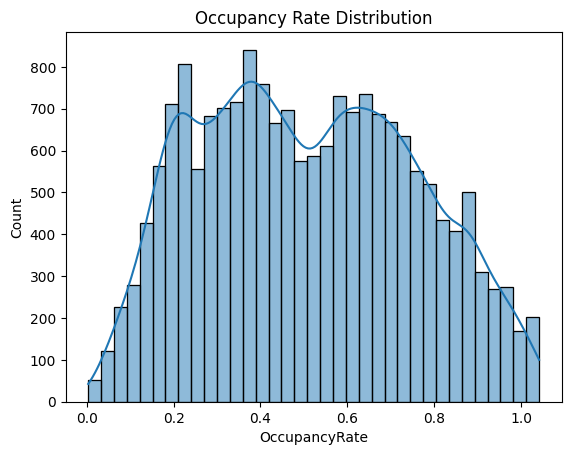

In [ ]:
sns.histplot(df['OccupancyRate'], kde=True)
plt.title("Occupancy Rate Distribution")
plt.show()

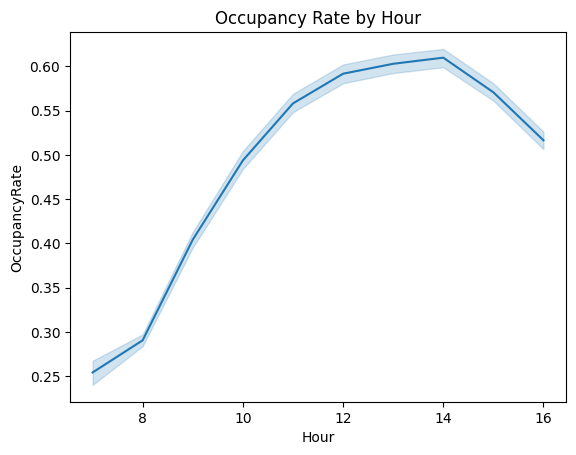

In [ ]:
sns.lineplot(data=df, x='Hour', y='OccupancyRate')
plt.title("Occupancy Rate by Hour")
plt.show()

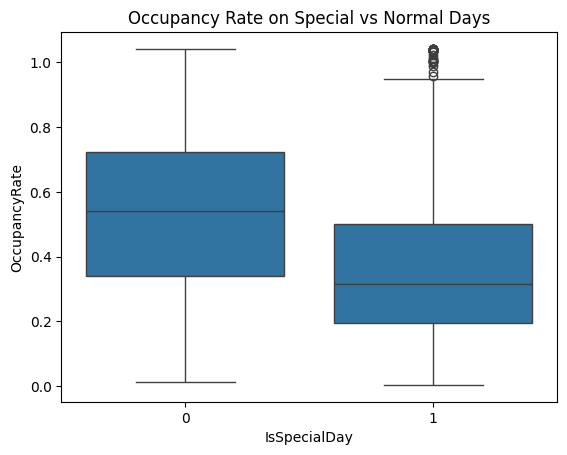

In [ ]:
sns.boxplot(data=df, x='IsSpecialDay', y='OccupancyRate')
plt.title("Occupancy Rate on Special vs Normal Days")
plt.show()

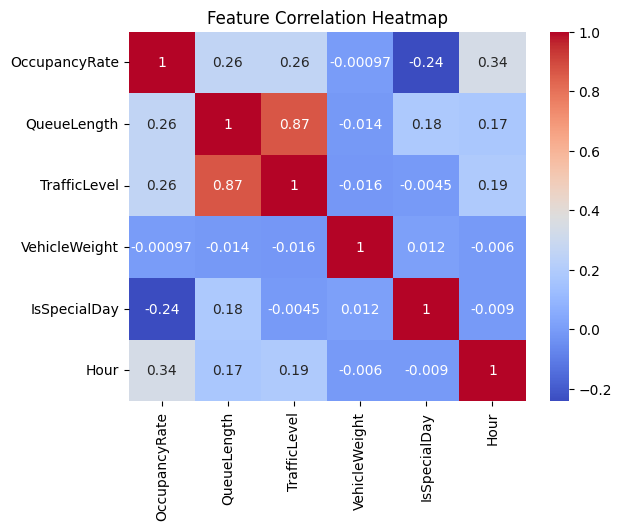

In [ ]:
corr = df[['OccupancyRate', 'QueueLength', 'TrafficLevel', 'VehicleWeight', 'IsSpecialDay','Hour']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

#MODEL 1: BASELINE PRICING MODEL

In [ ]:
import pandas as pd
import numpy as np

# Constants
BASE_PRICE = 10
ALPHA = 5

# Convert and clean timestamp
df["Timestamp"] = df["Timestamp"].astype(str).str.replace(r"\+00:00", "", regex=True)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Timestamp"] = df["Timestamp"].dt.tz_localize(None)
df["Day"] = df["Timestamp"].dt.date

# Sort by LotID and Timestamp
df = df.sort_values(["LotID", "Timestamp"]).reset_index(drop=True)

# Initialize baseline price column
df["BaselinePrice"] = BASE_PRICE

# Calculate baseline prices
for i in range(1, len(df)):
    same_lot = df.loc[i, 'LotID'] == df.loc[i - 1, 'LotID']
    same_day = df.loc[i, 'Day'] == df.loc[i - 1, 'Day']

    if same_lot and same_day:
        prev_price = df.loc[i - 1, 'BaselinePrice']
    else:
        prev_price = BASE_PRICE

    occ_rate = df.loc[i, 'OccupancyRate']
    df.loc[i, 'BaselinePrice'] = prev_price + ALPHA * occ_rate


# Export final results
df = df.sort_values(["LotID", "Timestamp"])

df["Timestamp"] = df["Timestamp"].astype(str).str.strip()  # <- remove trailing space
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Timestamp"] = df["Timestamp"].dt.strftime("%Y-%m-%d %H:%M:%S")
df.to_csv("prepriced.csv", index=False)


/tmp/ipython-input-17-4169931891.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.554592720970538' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'BaselinePrice'] = prev_price + ALPHA * occ_rate


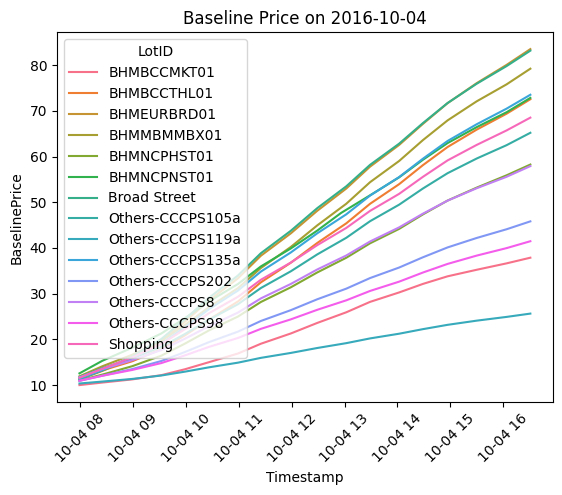

In [ ]:
sample_day = df['Day'].iloc[0]  # or any specific day
df_day = df[df['Day'] == sample_day]

sns.lineplot(data=df_day, x="Timestamp", y="BaselinePrice", hue="LotID")
plt.title(f"Baseline Price on {sample_day}")
plt.xticks(rotation=45)
plt.show()


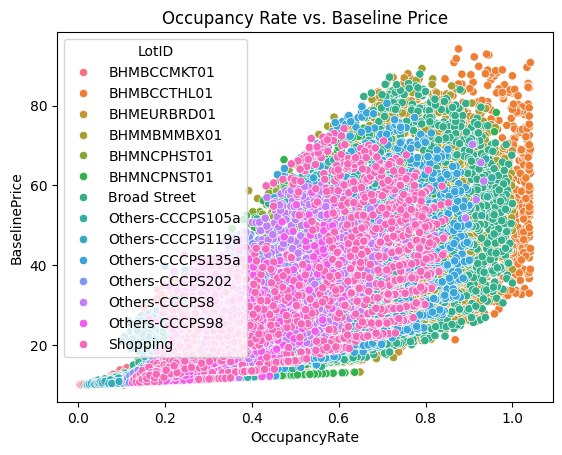

In [ ]:
sns.scatterplot(data=df, x="OccupancyRate", y="BaselinePrice", hue="LotID")
plt.title("Occupancy Rate vs. Baseline Price")
plt.show()

# Model 2

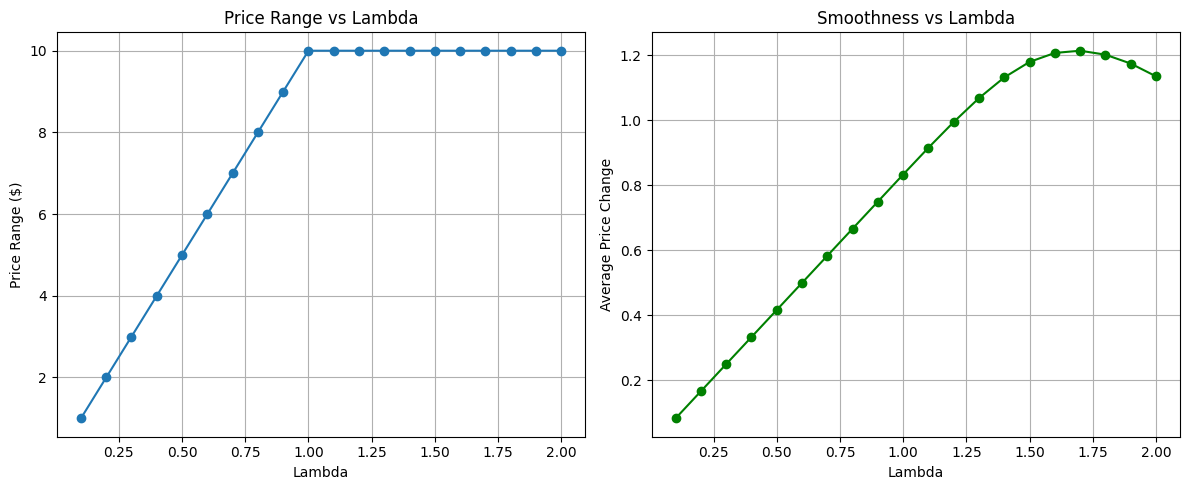

                  a    b    c    d    e  lambda  smoothness  price_range
Strict (==10)   2.0  1.0  0.5  1.0  0.5     1.0    0.529209         10.0
Flexible (>=9)  2.0  1.0  0.5  1.0  0.5     0.9    0.476288          9.0


/tmp/ipython-input-19-1408050743.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['Timestamp'] = pd.to_datetime(df_export['Timestamp'], errors='coerce')


0.03186019641825533 3.744186046511628


In [ ]:
# Re-import necessary packages after code execution environment reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['NormOccupancy'] = df['OccupancyRate']
df['NormQueue'] = df['QueueLength'] / df['QueueLength'].max()
df['NormTraffic'] = df['TrafficLevel'] / df['TrafficLevel'].max()
df['NormVehicle'] = df['VehicleWeight'] / df['VehicleWeight'].max()

# Setup base price
BASE_PRICE = 10

# Step 2: Grid search for best coefficients and lambda
a_vals = [1.0, 1.5, 2.0]
b_vals = [0.5, 1.0]
c_vals = [0.5, 1.0]
d_vals = [0.5, 1.0]
e_vals = [0.5, 1.0]
lambda_vals = np.linspace(0.1, 2.0, 20)

results = []

for a in a_vals:
    for b in b_vals:
        for c in c_vals:
            for d in d_vals:
                for e in e_vals:
                    df['Demand'] = (
                        a * df['NormOccupancy'] +
                        b * df['NormQueue'] -
                        c * df['NormTraffic'] +
                        d * df['IsSpecialDay'] +
                        e * df['NormVehicle']
                    )
                    df['NormDemand'] = (df['Demand'] - df['Demand'].min()) / (df['Demand'].max() - df['Demand'].min())

                    for lambda_ in lambda_vals:
                        df['DemandPrice'] = BASE_PRICE * (1 + lambda_ * df['NormDemand'])
                        df['DemandPrice'] = df['DemandPrice'].clip(lower=BASE_PRICE * 0.5, upper=BASE_PRICE * 2)

                        smoothness = df.groupby('LotID')['DemandPrice'].apply(lambda x: np.mean(np.abs(np.diff(x))))
                        avg_smoothness = smoothness.mean()
                        price_range = df['DemandPrice'].max() - df['DemandPrice'].min()

                        results.append({
                            'a': a, 'b': b, 'c': c, 'd': d, 'e': e,
                            'lambda': lambda_,
                            'smoothness': avg_smoothness,
                            'price_range': price_range
                        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# plot
lambda_plot_df = results_df.groupby('lambda').agg({
    'price_range': 'mean',
    'smoothness': 'mean'
}).reset_index()

plt.figure(figsize=(12, 5))

# 1. Price Range vs Lambda
plt.subplot(1, 2, 1)
plt.plot(lambda_plot_df['lambda'], lambda_plot_df['price_range'], marker='o')
plt.title("Price Range vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Price Range ($)")
plt.grid(True)

# 2. Smoothness vs Lambda
plt.subplot(1, 2, 2)
plt.plot(lambda_plot_df['lambda'], lambda_plot_df['smoothness'], marker='o', color='green')
plt.title("Smoothness vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Average Price Change")
plt.grid(True)

plt.tight_layout()
plt.show()


# Full range (strict)
strict_filtered = results_df[results_df['price_range'] == 10]

# Near-full range (flexible)
flex_filtered = results_df[results_df['price_range'] >= 9]

# Get smoothest model among full-range configs
best_strict = strict_filtered.sort_values(by='smoothness').iloc[0]

# Get smoothest model among near-full-range configs
best_flex = flex_filtered.sort_values(by='smoothness').iloc[0]

comparison_df = pd.DataFrame([best_strict, best_flex], index=['Strict (==10)', 'Flexible (>=9)'])
print(comparison_df[['a', 'b', 'c', 'd', 'e', 'lambda', 'smoothness', 'price_range']])


# Step 4: Recalculate DemandPrice with best values
a, b, c, d, e, lambda_ = best_strict[['a', 'b', 'c', 'd', 'e', 'lambda']]

df['Demand'] = (
    a * df['NormOccupancy'] +
    b * df['NormQueue'] -
    c * df['NormTraffic'] +
    d * df['IsSpecialDay'] +
    e * df['NormVehicle']
)
df['NormDemand'] = (df['Demand'] - df['Demand'].min()) / (df['Demand'].max() - df['Demand'].min())
df['DemandPrice'] = BASE_PRICE * (1 + lambda_ * df['NormDemand'])
df['DemandPrice'] = np.clip(df['DemandPrice'], BASE_PRICE * 0.5, BASE_PRICE * 2)

best_strict
df[['Timestamp', 'LotID', 'NormOccupancy', 'NormDemand', 'DemandPrice']].head()

df_export = df[[
    'Timestamp', 'LotID', 'NormOccupancy', 'NormQueue',
    'NormTraffic', 'IsSpecialDay', 'NormVehicle', 'DemandPrice'
]]

# Clean timestamp formatting
df_export['Timestamp'] = pd.to_datetime(df_export['Timestamp'], errors='coerce')
df_export = df_export.dropna(subset=['Timestamp'])
df_export['Timestamp'] = df_export['Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")

# Save
df_export.to_csv("prepriced_model2.csv", index=False)

demand_min = df['Demand'].min()
demand_max = df['Demand'].max()

print(demand_min, demand_max)


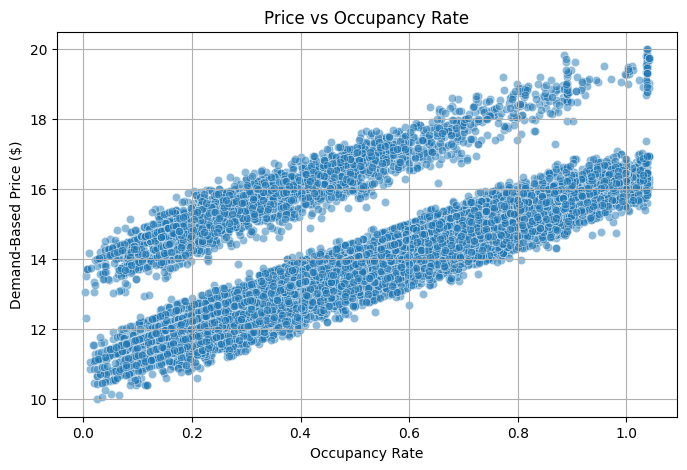

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(x='OccupancyRate', y='DemandPrice', data=df, alpha=0.5)
plt.title('Price vs Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Demand-Based Price ($)')
plt.grid(True)
plt.show()

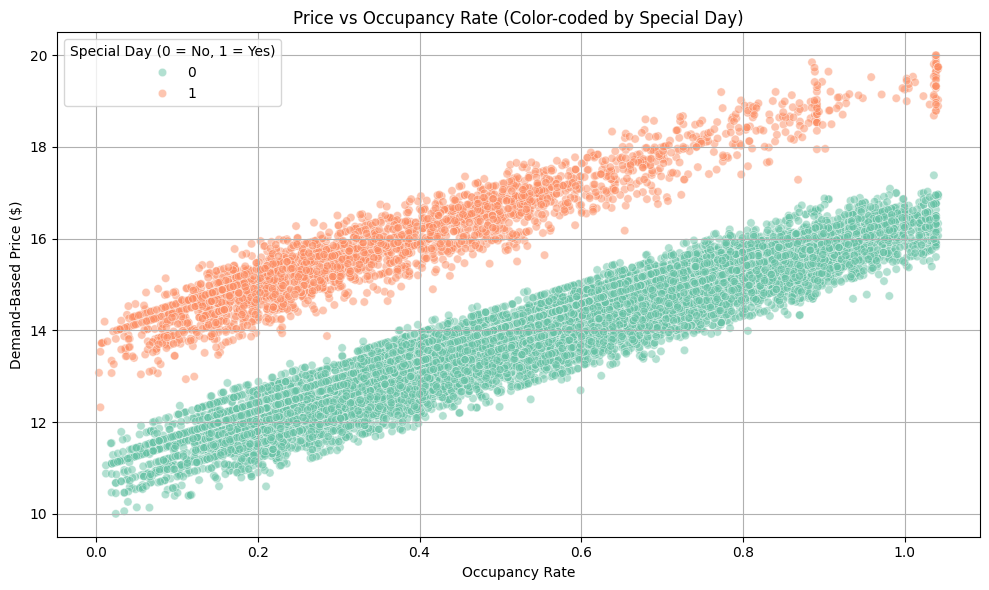

In [ ]:
df['IsSpecialDay'] = df['IsSpecialDay'].astype(int)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='OccupancyRate',
    y='DemandPrice',
    hue='IsSpecialDay',
    palette='Set2',
    alpha=0.5
)

plt.title("Price vs Occupancy Rate (Color-coded by Special Day)")
plt.xlabel("Occupancy Rate")
plt.ylabel("Demand-Based Price ($)")
plt.legend(title="Special Day (0 = No, 1 = Yes)")
plt.grid(True)
plt.tight_layout()
plt.show()


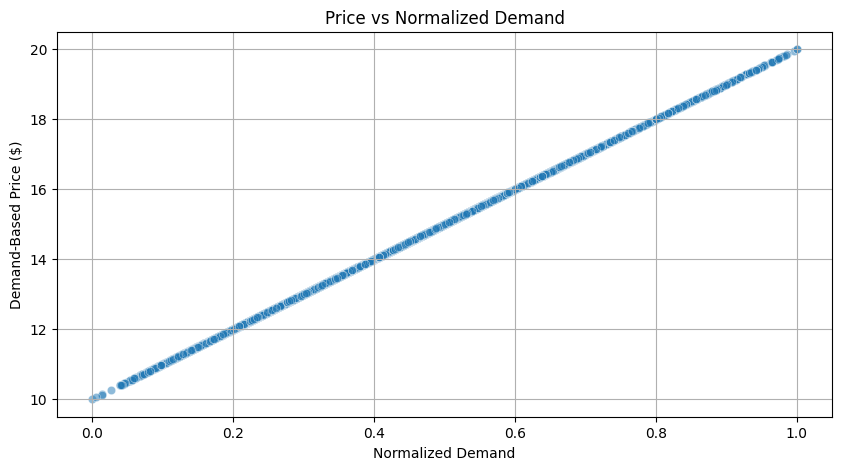

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['NormDemand'], y=df['DemandPrice'], alpha=0.5)
plt.title("Price vs Normalized Demand")
plt.xlabel("Normalized Demand")
plt.ylabel("Demand-Based Price ($)")
plt.grid(True)
plt.show()


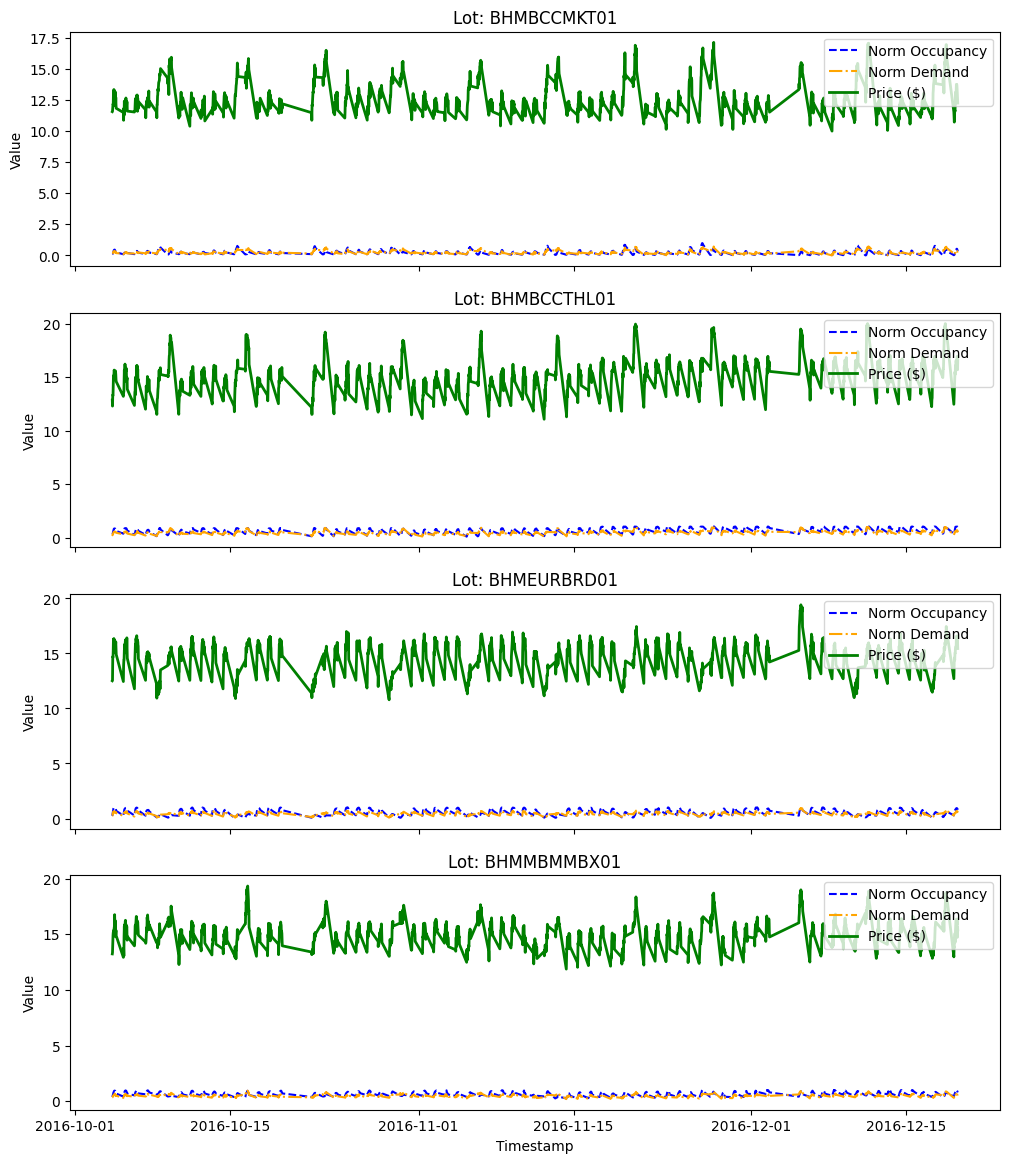

In [ ]:
sample_lots = df['LotID'].dropna().unique()[:4]
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

fig, axs = plt.subplots(len(sample_lots), 1, figsize=(12, 14), sharex=True)

for i, lot in enumerate(sample_lots):
    lot_df = df[df['LotID'] == lot].sort_values(by='Timestamp')

    axs[i].plot(lot_df['Timestamp'], lot_df['OccupancyRate'], label='Norm Occupancy', color='blue', linestyle='--')
    axs[i].plot(lot_df['Timestamp'], lot_df['NormDemand'], label='Norm Demand', color='orange', linestyle='-.')
    axs[i].plot(lot_df['Timestamp'], lot_df['DemandPrice'], label='Price ($)', color='green', linewidth=2)

    axs[i].set_title(f"Lot: {lot}")
    axs[i].set_ylabel("Value")
    axs[i].legend(loc='upper right')

plt.xlabel("Timestamp")
plt.show()

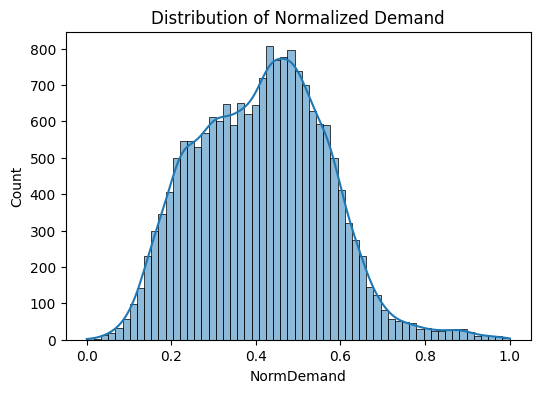

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df['NormDemand'], kde=True)
plt.title('Distribution of Normalized Demand')
plt.show()


# comparing both models

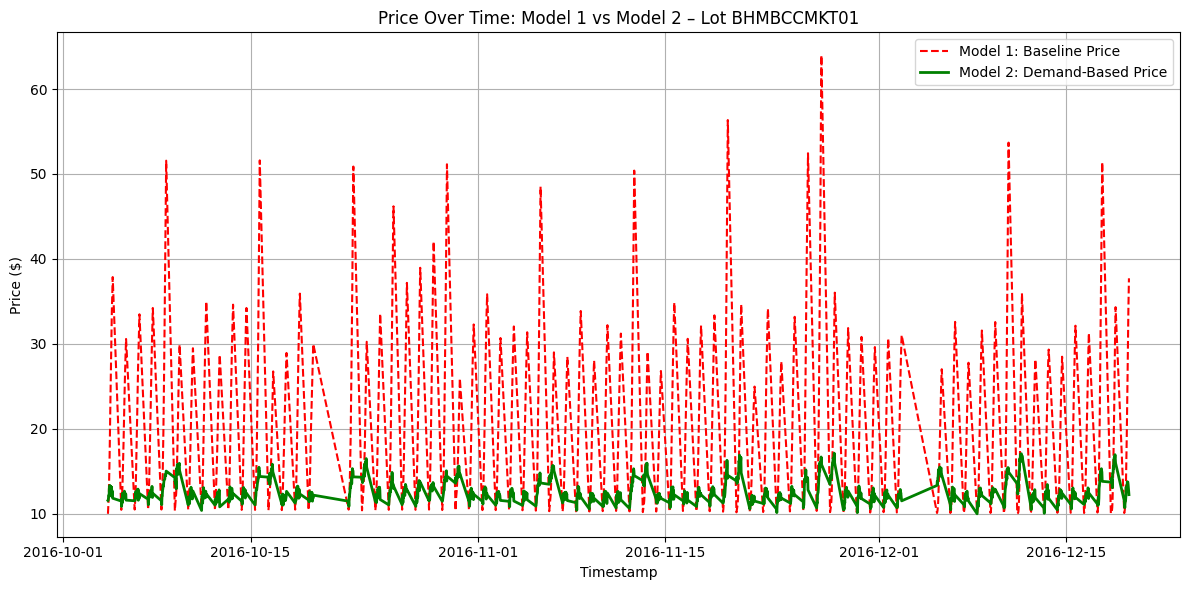

In [ ]:
sample_lot = df['LotID'].dropna().unique()[0]
lot_df = df[df['LotID'] == sample_lot].sort_values(by='Timestamp')

plt.figure(figsize=(12, 6))
plt.plot(lot_df['Timestamp'], lot_df['BaselinePrice'], label='Model 1: Baseline Price', linestyle='--', color='red')
plt.plot(lot_df['Timestamp'], lot_df['DemandPrice'], label='Model 2: Demand-Based Price', linewidth=2, color='green')
plt.title(f"Price Over Time: Model 1 vs Model 2 – Lot {sample_lot}")
plt.xlabel("Timestamp")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df['PriceChange_M1'] = df['BaselinePrice'].diff().abs()
df['PriceChange_M2'] = df['DemandPrice'].diff().abs()

print("Volatility Comparison:")
print("Model 1:", df['PriceChange_M1'].mean())
print("Model 2:", df['PriceChange_M2'].mean())

Volatility Comparison:
Model 1: 4.9474156197003225
Model 2: 0.5302923519451958


# pathway

In [ ]:
!pip install pathway --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install bokeh --quiet
!pip install panel --quiet

model 1

In [ ]:
import pathway as pw
import os

# Step 1: Schema
class PriceSchema(pw.Schema):
    Timestamp: str
    LotID: str
    OccupancyRate: float
    BaselinePrice: float

# Step 2: Replay CSV stream
data = pw.demo.replay_csv("prepriced.csv", schema=PriceSchema, input_rate=200)

# Step 3: Parse timestamp
data = data.with_columns(
    t = pw.this.Timestamp.dt.strptime("%Y-%m-%d %H:%M:%S")  # Do not change
)

# Step 4: Select output
result = data.select(
    t = pw.this.t,
    LotID = pw.this.LotID,
    BaselinePrice = pw.this.BaselinePrice
)

# Step 5: Output to file
os.makedirs("output", exist_ok=True)
pw.io.jsonlines.write(result, "output/streamed_baseline.jsonl")

# Step 6: Run
pw.run()


Output()

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [ ]:
import pandas as pd
import panel as pn
import time
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from threading import Thread
from bokeh.palettes import Category20_20  # 20 distinct colors

# Enable Panel for interactive plotting in Colab
pn.extension('tabulator', sizing_mode="stretch_width")

# Load initial data to extract LotIDs
df_init = pd.read_json("output/streamed_baseline.jsonl", lines=True)
lot_ids = sorted(df_init["LotID"].unique())

# Create a ColumnDataSource for each LotID
sources = {lot: ColumnDataSource(data=dict(t=[], price=[])) for lot in lot_ids}

# Assign distinct colors (use Category20 or extend if more)
palette = Category20_20 * ((len(lot_ids) // 20) + 1)  # Extend color palette if more than 20
colors = {lot: palette[i] for i, lot in enumerate(lot_ids)}

# Create one plot per lot with unique color
plots = []
for lot in lot_ids:
    p = figure(
        title=f"Real-Time Baseline Price: Lot {lot}",
        x_axis_type="datetime",
        height=250,
        width=600
    )
    p.line(x='t', y='price', source=sources[lot], line_width=2, color=colors[lot])
    p.circle(
    x='t', y='price',
    source=sources[lot],
    size=5,
    fill_color=None,    # No fill color
    fill_alpha=0.5,     # Fully transparent
    line_color=None     # No outline
)
    plots.append(pn.Card(p, title=f"Lot {lot}", collapsible=True))

# Panel layout to display all
layout = pn.Column(*plots, scroll=True)

# Background thread to stream updates
def update_stream():
    seen = set()
    while True:
        try:
            df = pd.read_json("output/streamed_baseline.jsonl", lines=True)
            df["t"] = pd.to_datetime(df["t"], errors="coerce")
            df = df.dropna(subset=["t"])
            new_rows = df[~df["t"].astype(str).isin(seen)]

            if not new_rows.empty:
                for lot in lot_ids:
                    df_lot = new_rows[new_rows["LotID"] == lot]
                    if not df_lot.empty:
                        sources[lot].stream({
                            't': df_lot["t"],
                            'price': df_lot["BaselinePrice"]
                        }, rollover=300)
                seen.update(new_rows["t"].astype(str))
        except Exception as e:
            print("Stream error:", e)
        time.sleep(1)

# Start background thread
Thread(target=update_stream, daemon=True).start()

# Show in Colab or Jupyter
layout.servable()


Column(scroll=True, sizing_mode='stretch_width')
    [0] Card(sizing_mode='stretch_width', title='Lot BHMBCCMKT01')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [1] Card(sizing_mode='stretch_width', title='Lot BHMBCCTHL01')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [2] Card(sizing_mode='stretch_width', title='Lot BHMEURBRD01')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [3] Card(sizing_mode='stretch_width', title='Lot BHMMBMMBX01')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [4] Card(sizing_mode='stretch_width', title='Lot BHMNCPHST01')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [5] Card(sizing_mode='stretch_width', title='Lot BHMNCPNST01')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [6] Card(sizing_mode='stretch_width', title='Lot Broad Street')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [7] Card(sizing_mode='stretch_width', title='Lot Others-CCCPS105a')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [8] Card(sizing_mode='stretch_width', title='Lot Others-CCCPS119a')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [9] Card(sizing_mode='stretch_width', title='Lot Others-CCCPS135a')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [10] Card(sizing_mode='stretch_width', title='Lot Others-CCCPS202')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [11] Card(sizing_mode='stretch_width', title='Lot Others-CCCPS8')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [12] Card(sizing_mode='stretch_width', title='Lot Others-CCCPS98')
        [0] Bokeh(figure, sizing_mode='stretch_width')
    [13] Card(sizing_mode='stretch_width', title='Lot Shopping')
        [0] Bokeh(figure, sizing_mode='stretch_width')

# model 2

In [ ]:
import pathway as pw

class PrepricedModel2Schema(pw.Schema):
    Timestamp: str
    LotID: str
    NormOccupancy: float
    NormQueue: float
    NormTraffic: float
    IsSpecialDay: int
    NormVehicle: float
    DemandPrice: float

In [ ]:
data = pw.demo.replay_csv("prepriced_model2.csv", schema=PrepricedModel2Schema, input_rate=1000)

In [ ]:
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00"),
    hours = data.Timestamp.dt.strptime(fmt).dt.hour()
)

In [ ]:
import pathway as pw
import numpy as np
import datetime

# Constants from your best model
a, b, c, d, e = 2.0, 1.0, 0.5, 1.0 , 0.5  # Example values
BASE_PRICE = 10
lambda_ = 1  # Example best lambda

reduced = (
    data_with_time.windowby(
        pw.this.t,
        window=pw.temporal.tumbling(datetime.timedelta(hours=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t = pw.this._pw_window_end,
        occ_sum = pw.reducers.sum(pw.this.NormOccupancy),
        queue_sum = pw.reducers.sum(pw.this.NormQueue),
        traffic_sum = pw.reducers.sum(pw.this.NormTraffic),
        vehicle_sum = pw.reducers.sum(pw.this.NormVehicle),
        special_any = pw.reducers.max(pw.this.IsSpecialDay),
        lot = pw.reducers.min(pw.this.LotID),
        n = pw.reducers.count()
    )
    .with_columns(
        occ_avg = pw.this.occ_sum / pw.this.n,
        queue_avg = pw.this.queue_sum / pw.this.n,
        traffic_avg = pw.this.traffic_sum / pw.this.n,
        vehicle_avg = pw.this.vehicle_sum / pw.this.n
    )
)


# Apply model directly with demand and price calculation
final = reduced.with_columns(
    demand=(
        a * pw.this.occ_avg +
        b * pw.this.queue_avg -
        c * pw.this.traffic_avg +
        d * pw.this.special_any +
        e * pw.this.vehicle_avg
    )
)

# Use a fixed min/max to normalize (e.g., from prior analysis)
demand_min = 0.0
demand_max = 4.0

# Step 1: Compute norm_demand
final = final.with_columns(
    norm_demand=(pw.this.demand - demand_min) / (demand_max - demand_min + 1e-8)
)

# Step 2: Compute DemandPriceLive using norm_demand
final = final.with_columns(
    DemandPriceLive=pw.apply(
        lambda norm_d: np.clip(BASE_PRICE * (1 + lambda_ * norm_d), BASE_PRICE * 0.5, BASE_PRICE * 2),
        pw.this.norm_demand
    )
)


# Output
final_output = final.select(
    t=pw.this.t,
    LotID=pw.this.lot,
    DemandPriceLive=pw.this.DemandPriceLive
)

pw.io.jsonlines.write(
    final_output,
    "output/prepriced_model2.jsonl"
)

pw.run()

Output()

Stream error: 't'

In [ ]:
import pandas as pd
import panel as pn
import time
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from threading import Thread
from bokeh.palettes import Category20_20  # 20 distinct colors

# Enable Panel for interactive plotting in Colab
pn.extension('tabulator', sizing_mode="stretch_width")

# Load initial data to extract LotIDs
df_init = pd.read_json("output/prepriced_model2.jsonl", lines=True)
lot_ids = sorted(df_init["LotID"].unique())

# Create a ColumnDataSource for each LotID
sources = {lot: ColumnDataSource(data=dict(t=[], price=[])) for lot in lot_ids}

# Assign distinct colors (use Category20 or extend if more)
palette = Category20_20 * ((len(lot_ids) // 20) + 1)  # Extend color palette if more than 20
colors = {lot: palette[i] for i, lot in enumerate(lot_ids)}

# Create one plot per lot with unique color
plots = []
for lot in lot_ids:
    p = figure(
        title=f"Real-Time Baseline Price: Lot {lot}",
        x_axis_type="datetime",
        height=250,
        width=600
    )
    p.line(x='t', y='price', source=sources[lot], line_width=2, color=colors[lot])
    p.circle(
    x='t', y='price',
    source=sources[lot],
    size=5,
    fill_color=None,    # No fill color
    fill_alpha=0.5,     # Fully transparent
    line_color=None     # No outline
)
    plots.append(pn.Card(p, title=f"Lot {lot}", collapsible=True))

# Panel layout to display all
layout = pn.Column(*plots, scroll=True)

# Background thread to stream updates
def update_stream():
    seen = set()
    while True:
        try:
            df = pd.read_json("output/prepriced_model2.jsonl", lines=True)
            df["t"] = pd.to_datetime(df["t"], errors="coerce")
            df = df.dropna(subset=["t"])
            new_rows = df[~df["t"].astype(str).isin(seen)]

            if not new_rows.empty:
                for lot in lot_ids:
                    df_lot = new_rows[new_rows["LotID"] == lot]
                    if not df_lot.empty:
                        sources[lot].stream({
                            't': df_lot["t"],
                            'price': df_lot["DemandPriceLive"]
                        }, rollover=300)
                seen.update(new_rows["t"].astype(str))
        except Exception as e:
            print("Stream error:", e)
        time.sleep(1)

# Start background thread
Thread(target=update_stream, daemon=True).start()

# Show in Colab or Jupyter
layout.servable()


Column(scroll=True, sizing_mode='stretch_width')
    [0] Card(sizing_mode='stretch_width', title='Lot BHMBCCMKT01')
        [0] Bokeh(figure, sizing_mode='stretch_width')